# Code to generate manuscript figures

This notebook can be used to plot figures in the manuscript. Please note that we use bigger values for the, population size, number of networks, number of preference configurations and number of replicates for the figures in the paper, computations for which were done on a cluster. Here we work with smaller values for the above mentioned parameters for computational ease to demonstrate how the model has been implemented.

In [1]:
#pip install networkx
#pip install seaborn


In [29]:
import random
import time
import itertools
import multiprocessing as mp
from simulation import simulation
import numpy as np
from generate_preference_distribution import gen_gamma
from generate_network import gen_net
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import seaborn as sns
from strategy_name import strategy_name
%matplotlib inline

In [ ]:
"""
This function identifies the minimum intervention size required for a given strategy and given population to reach a required level of adoption. . 
It returns the incentive cost, time taken to reach required adoption level, the Gini coefficientsof incentives given within the target group and the whole population. 
"""
def min_intervention(N,num_of_iter,num_of_replicates, A, gamma, penalty, strategy_type, criteria_value, req):
    
    a=0.0 
    b=1.0
    
    while (b-a)>0.01:
        
        mid=(a+b)/2
        _,_,final_adoption,_,_=simulation(N, num_of_iter, num_of_replicates, A, gamma, penalty, strategy_type, mid, criteria_value, req)
        
        if final_adoption>req:
            b=mid
        else:
            a=mid
    incentive_cost,time_taken,final_adoption,G,G_all=simulation(N, num_of_iter, num_of_replicates, A, gamma, penalty, strategy_type, b, criteria_value,  req)    
             
    return incentive_cost,time_taken,final_adoption,b,G,G_all

In [17]:
print(mp.cpu_count())
p = mp.Pool(processes=mp.cpu_count())

192


In [18]:
req=0.90 # level of adoption required 
N=500
z=10

V=5 # this is used to scale the preference distubutions
penalty=0.5

num_of_iter=20*N

num_of_networks=25
num_of_replicates=25
num_of_gamma_configs=25

#strategy_type=0 for random, 11 for resistant, 10 for amenable, 20 for high degree,21 for low degre, 40 for high clustering, 41 for low clustering, 50 for high influence/cost

strategy_list=[0,11,10,20,21,40,41]

strategy_labels=np.array([strategy_name(strategy_type) for strategy_type in strategy_list])

network_labels = {1: "Erdos-Reyni Network", 2: "Watts-Strogatz Network", 3: "Barabasi-Albert Network", 41: "Homophilic Homogenous Network", 43: "Homophilic Heterogenous Network"}


## Figure 1: Strategies Based on Preference Distributions

In this figure, we compare targeting strategies that rely solely on information about the distribution of intrinsic preferences. 
The preference distributions are modeled using a transformed Beta distribution (Beta(α, α)), where the parameter α controls homogeneity. 
As described in the manuscript, among the preference-informed strategies, targeting the more amenable individuals (those with a higher propensity for change) emerges as the most cost-effective option across a wide range of average preference values.

In [19]:



param_spacing=7

#parameters of preference distribution
mu_list=np.linspace(0.7,-0.4,param_spacing)
alpha_list=np.logspace(np.log10(0.5),np.log10(100),param_spacing) #alpha parameter for beta function underlying preference distribution





network=3 # BA network


st = time.time()
# generating preference values for populations
input_list= np.array([(N,mu,network,alpha,V) for mu,alpha,ii in itertools.product(mu_list,alpha_list,range(num_of_gamma_configs))], dtype=object)

gamma_list=p.starmap(gen_gamma,input_list)

rnd=666
rnd_list=range(666,666+num_of_networks)

# generating networks as well as criteria for network based strategies 
input_list= np.array([(network,N,z,0.5,rnd,strategy_type,0.5) for rnd,strategy_type in itertools.product(rnd_list,strategy_list)], dtype=object)
A_list,criteria_value_list=zip(*p.starmap(gen_net,input_list))

et = time.time()

# get the initialization time
elapsed_time = et - st

print('Initialization time:', elapsed_time, 'seconds')

Initialization time: 0.19106507301330566 seconds


In [20]:
st = time.time()


input_list = np.array([(N, num_of_iter, num_of_replicates, A_list[ii], gamma_list[i], penalty, strategy_list[ii%len(strategy_list)], criteria_value_list[ii], req) 
     for i, ii in itertools.product(range(len(gamma_list)), range(len(A_list)))], dtype=object)

incentive_cost,time_taken,final_adoption,phi_min,G,G_all= zip(*p.starmap(min_intervention, input_list))


 # get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 408.38367557525635 seconds


In [24]:
incentive_cost=np.array(incentive_cost)
incentive_cost.shape=(len(mu_list),len(alpha_list),num_of_gamma_configs*num_of_networks,len(strategy_list))


phi_min=np.array(phi_min)
phi_min.shape=(len(mu_list),len(alpha_list),num_of_gamma_configs*num_of_networks,len(strategy_list))

In [25]:
palette = sns.color_palette("Paired")

# Convert it to a list of colors
paired_colors = list(palette)
colors=['slategray']
for i in range(6):
    colors.append(paired_colors[i])
colors.append(paired_colors[8])

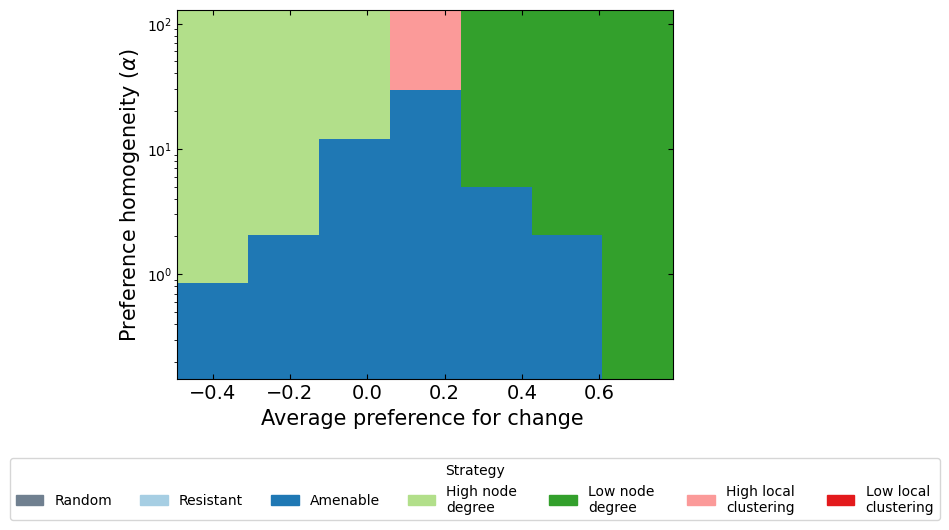

In [36]:
mean1=np.nanmean(incentive_cost,axis=2)

#selected=[0,1,2]  # for preference based strategies
#selected=[0,3,4,5,6]  # for network based strategies
selected=[0,1,2,3,4,5,6]  # for all strategies
cost_optimal_strategy=np.zeros((len(mu_list),len(alpha_list)))

for i,mu in enumerate(mu_list[:]):
    for j,alpha in enumerate(alpha_list):
        temp1=mean1[i,j,selected]
        
        pos=np.where(temp1 == temp1.min())
        
        cost_optimal_strategy[i,j]=selected[np.nanargmin(temp1)]
           
fig, ax = plt.subplots()
cmap = ListedColormap(colors)
boundaries = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
X, Y = np.meshgrid(mu_list, alpha_list)

ax.pcolormesh(X, Y, cost_optimal_strategy.T, cmap=cmap, norm=norm,shading='auto')

ax.set_ylabel(r'Preference homogeneity ($\alpha$)',fontsize=15)

ax.set_xlabel('Average preference for change ',fontsize=15)
plt.xticks(fontsize=14)
plt.yscale("log")


ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")
handles, labels = ax.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors[i], label=strategy_labels[i]) for i in selected ]
handles.extend(patches)
lgd=ax.legend(handles=handles,loc='lower center',title='Strategy',fontsize="10", bbox_to_anchor=(0.6, -0.40),ncol=8, fancybox=True)



## Figure 2: Optimal Strategies in Segregated and Clustered Populations

This figure examines the performance of targeting strategies in networks with varying levels of homophily (segregation). 
Using a homophilous Barabási–Albert network, the analysis shows that while preference-based strategies perform well in low-homophily settings, 
network-informed strategies (which target agents based on network properties such as degree or clustering) become increasingly effective as segregation increases.

These results support the manuscript’s discussion on how network structure modulates the efficiency of different intervention approaches.

In [38]:
param_spacing=7
    
#parameters of preference distribution
mu_list=np.linspace(0.7,-0.4,param_spacing)
alpha=2
    


network=43 # Preferential attachment with homophily
p_in_list=np.linspace(0.5,0.95,param_spacing) #corresponds to homphily ranging from 0 to 0.9


# generating preference values for populations
input_list= np.array([(N,mu,network,alpha,V) for mu,ii in itertools.product(mu_list,range(num_of_gamma_configs))], dtype=object)
gamma_list=p.starmap(gen_gamma,input_list)


st = time.time()

rnd=666
rnd_list=range(666,666+num_of_networks)

# generating networks as well as criteria for network based strategies 
input_list= np.array([(network,N,z,0.5,rnd,strategy_type,p_in) for rnd,p_in,strategy_type in itertools.product(rnd_list,p_in_list,strategy_list)], dtype=object)
A_list,criteria_value_list=zip(*p.starmap(gen_net,input_list))

et = time.time()

# get the initialization time
elapsed_time = et - st

print('Initialization time:', elapsed_time, 'seconds')

Initialization time: 3.092728853225708 seconds


In [40]:
st = time.time()

input_list = np.array([(N, num_of_iter, num_of_replicates, A_list[ii], gamma_list[i], penalty, strategy_list[ii%len(strategy_list)], criteria_value_list[ii], req) 
                          for i, ii in itertools.product(range(len(gamma_list)), range(len(A_list)))], dtype=object)

incentive_cost,time_taken,final_adoption,phi_min,G,G_all= zip(*p.starmap(min_intervention, input_list))

 # get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 383.9111077785492 seconds


In [50]:
incentive_cost=np.array(incentive_cost)
incentive_cost.shape=(len(mu_list),num_of_gamma_configs*num_of_networks,len(p_in_list),len(strategy_list))


phi_min=np.array(phi_min)
phi_min.shape=(len(mu_list),num_of_gamma_configs*num_of_networks,len(p_in_list),len(strategy_list))



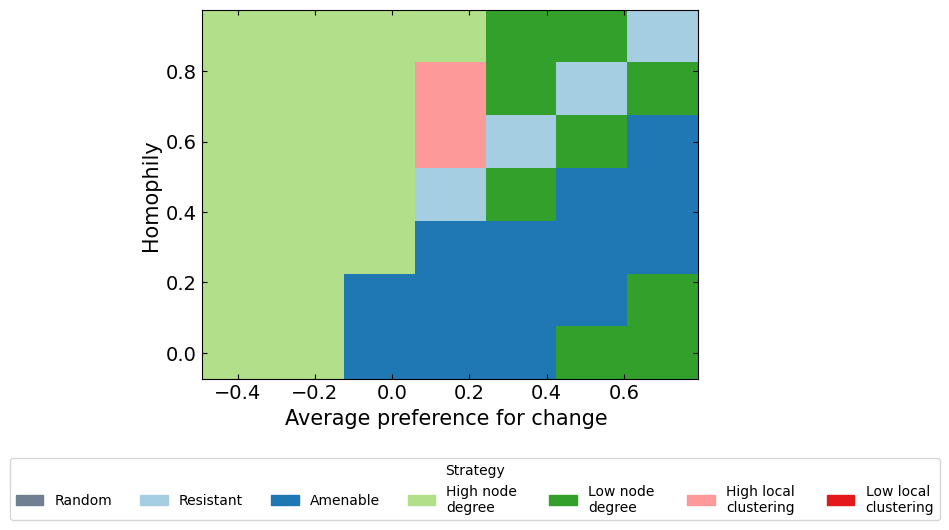

In [53]:
mean1=np.nanmean(incentive_cost,axis=1)


#selected=[0,1,2]  # for preference based strategies
#selected=[0,3,4,5,6]  # for network based strategies
selected=[0,1,2,3,4,5,6]  # for all strategies

cost_optimal_strategy=np.zeros((len(mu_list),len(p_in_list)))
for i,mu in enumerate(mu_list):
    for j,p_in in enumerate(p_in_list):
        temp1=mean1[i,j,selected]
        
        #identify cost effective strategy
        cost_optimal_strategy[i,j]=selected[np.argmin(temp1)]
           
fig, ax = plt.subplots()
cmap = ListedColormap(colors)
boundaries = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)


X, Y = np.meshgrid(mu_list, (p_in_list-0.5)*2)

plt.pcolormesh(X, Y, cost_optimal_strategy.T, cmap=cmap, norm=norm,shading='auto')

ax.set_ylabel('Homophily',fontsize=15)

ax.set_xlabel('Average preference for change ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")
handles, labels = ax.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors[i], label=strategy_labels[i]) for i in selected ]
handles.extend(patches)
lgd=ax.legend(handles=handles,loc='lower center',title='Strategy',fontsize="10", bbox_to_anchor=(0.55, -0.40),ncol=8, fancybox=True)

## Setting up population for Fig 3 (A,B) and Fig 4 (A,B,C,D)

Figure 3 illustrates the trade-off between intervention cost and the time required to achieve 90% adoption of the new behavior. 
Time is measured in generations (time steps) and reflects the dynamics of adoption as influenced by the chosen targeting strategy. 



In Figure 4, the Gini coefficient is used as a measure of the inequality in the distribution of incentives. 
The analysis is performed separately for the target group and the overall population. 



In [102]:
#parameters of gamma distribution
mu=0.2
alpha=2

network=3 # BA network

phi_range_size=10
phi_limit=req

In [103]:
# generating preference values for populations
input_list= np.array([(N,mu,network,alpha,V) for ii in range(num_of_gamma_configs)], dtype=object)
gamma_list=p.starmap(gen_gamma,input_list)

rnd=666
rnd_list=range(666,666+num_of_networks)

# generating networks as well as criteria for network based strategies 
input_list= np.array([(network,N,z,0.5,rnd,strategy_type,0) for rnd,strategy_type in itertools.product(rnd_list,strategy_list)], dtype=object)
A_list,criteria_value_list=zip(*p.starmap(gen_net,input_list))

In [104]:
st = time.time()

incentive_cost=np.zeros((len(strategy_list),num_of_gamma_configs*num_of_networks,phi_range_size))
final_adoption=np.zeros_like(incentive_cost)
time_taken=np.zeros_like(incentive_cost)
G=np.zeros_like(incentive_cost)
G_all=np.zeros_like(incentive_cost)
phi_list=np.zeros((len(strategy_list),phi_range_size))


#identifying the minimum invervention for all strategies
input_list = np.array([(N, num_of_iter, num_of_replicates, A_list[ii],  gamma_list[i], penalty, strategy_list[ii%len(strategy_list)], criteria_value_list[ii], req) 
                       for i, ii in itertools.product(range(len(gamma_list)), range(len(A_list)))], dtype=object)
incentive_cost1,time_taken1,final_adoption1,phi_min1,G1,G_all1= zip(*p.starmap(min_intervention, input_list))

A_list=np.array(A_list)
A_list.shape=(num_of_networks,len(strategy_list),N,N)

criteria_value_list=np.array(criteria_value_list)
criteria_value_list.shape=(num_of_networks,len(strategy_list),N)

incentive_cost1=np.array(incentive_cost1)
incentive_cost1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))

final_adoption1=np.array(final_adoption1)
final_adoption1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))



time_taken1=np.array(time_taken1)
time_taken1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))

G1=np.array(G1)
G1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))
G_all1=np.array(G_all1)
G_all1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))


phi_min1=np.array(phi_min1)
phi_min1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))
phi_min_mean=np.mean(phi_min1,axis=0)
phi_list[:,0]=phi_min_mean

for ii,strategy_type in enumerate(strategy_list):
            
    incentive_cost[ii,:,0]=incentive_cost1[:,ii]
    time_taken[ii,:,0]=time_taken1[:,ii]
    final_adoption[ii,:,0]=final_adoption1[:,ii]
    G[ii,:,0]=G1[:,ii]
    G_all[ii,:,0]=G_all1[:,ii]

    A_list1=list(A_list[:,ii,:,:])
    criteria_value_list1=list(criteria_value_list[:,ii,:])     

    phi_list1=np.linspace(phi_min_mean[ii],phi_limit,phi_range_size)

    # Looking at interventions beyond the minimum intervention size
    input_list = np.array([(N,num_of_iter,num_of_replicates,A_list1[ii],gamma_list[i],penalty,strategy_type,phi,criteria_value_list1[ii],req) for i,ii,phi in itertools.product(range(len(gamma_list)),range(len(A_list1)),phi_list1[1:])],dtype=object)
    incentive_cost2,time_taken2,final_adoption2,G2,G_all2 =zip(*p.starmap(simulation,input_list))

    incentive_cost2=np.array(incentive_cost2)
    incentive_cost2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    incentive_cost[ii,:,1:]=incentive_cost2

    final_adoption2=np.array(final_adoption2)
    final_adoption2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    final_adoption[ii,:,1:]=final_adoption2


    time_taken2=np.array(time_taken2)
    time_taken2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    time_taken[ii,:,1:]=time_taken2

    G2=np.array(G2)
    G2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    G[ii,:,1:]=G2

    G_all2=np.array(G_all2)
    G_all2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    G_all[ii,:,1:]=G_all2

    phi_list[ii,1:]=phi_list1[1:]

# get the end time
et = time.time()    
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 19.329472303390503 seconds


In [105]:
spread=[5,95]
mean_cost=np.nanmean(incentive_cost,axis=1)
lower_cost= np.nanpercentile(incentive_cost,spread[0],axis=1)
upper_cost= np.nanpercentile(incentive_cost,spread[1],axis=1)

mean_time=np.nanmean(time_taken,axis=1)
lower_time= np.nanpercentile(time_taken,spread[0],axis=1)
upper_time= np.nanpercentile(time_taken,spread[1],axis=1)

mean_G=np.nanmean(G,axis=1)
lower_G= np.nanpercentile(G,spread[0],axis=1)
upper_G= np.nanpercentile(G,spread[1],axis=1)

mean_G_all=np.nanmean(G_all,axis=1)
lower_G_all= np.nanpercentile(G_all,spread[0],axis=1)
upper_G_all= np.nanpercentile(G_all,spread[1],axis=1)



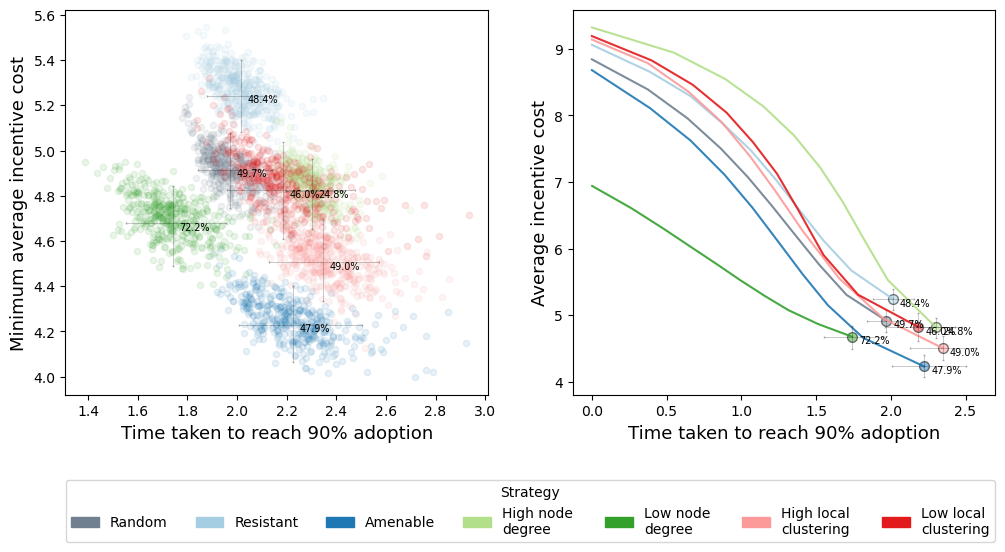

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 5))


for i in selected:
                
    ax2.plot(mean_time[i],mean_cost[i],color=colors[i],alpha=0.9)
                                  
    x=mean_time[i,0]
    y=mean_cost[i,0]
    

    xerr1=np.array([x-lower_time[i,0],upper_time[i,0]-x])
    yerr1=np.array([y-lower_cost[i,0],upper_cost[i,0]-y])

    ax2.scatter(x,y,color=colors[i],marker='o', s=50,edgecolor='k',alpha=0.5)
    ax1.scatter(time_taken[i,:,0],incentive_cost[i,:,0],color=colors[i],marker='o', s=20,edgecolor=None,alpha=0.1)
    


    ax1.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax1.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    ax2.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax2.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    
ax2.set_ylabel('Average incentive cost',size=13)
ax1.set_ylabel('Minimum average incentive cost',size=13)
ax1.set_xlabel('Time taken to reach '+ str(int(req*100))+'% adoption',size=13)
ax2.set_xlabel('Time taken to reach '+ str(int(req*100))+'% adoption',size=13)


handles, labels = ax1.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors[i], label=strategy_labels[i]) for i in selected ]
handles.extend(patches)
lgd=ax1.legend(handles=handles,loc='lower center',title='Strategy',fontsize="10", bbox_to_anchor=(1.1, -0.40),ncol=8, fancybox=True)

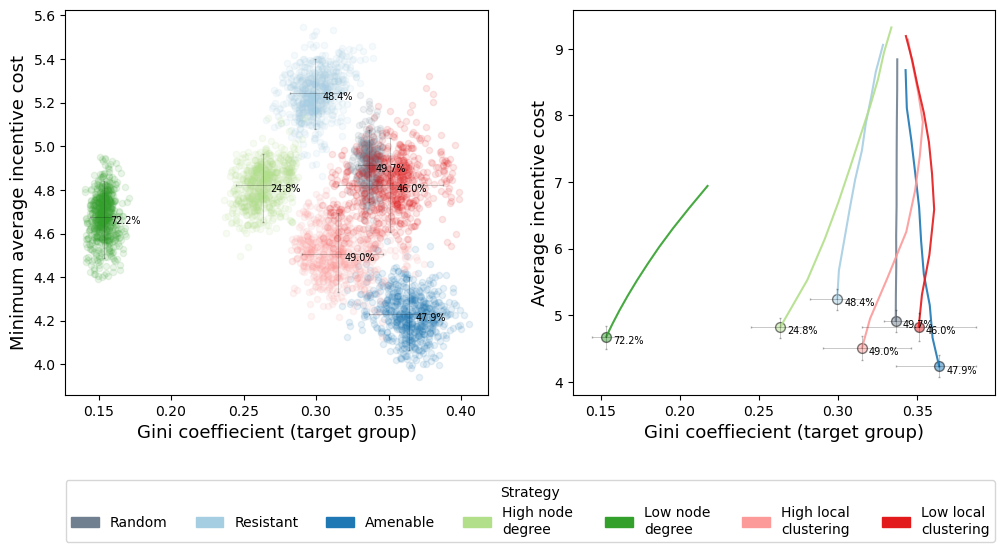

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 5))

for i in selected:
                
    ax2.plot(mean_G[i],mean_cost[i],color=colors[i],alpha=0.9)
                                  
    x=mean_G[i,0]
    y=mean_cost[i,0]
    

    xerr1=np.array([x-lower_G[i,0],upper_G[i,0]-x])
    yerr1=np.array([y-lower_cost[i,0],upper_cost[i,0]-y])

    ax2.scatter(x,y,color=colors[i],marker='o', s=50,edgecolor='k',alpha=0.5)
    ax1.scatter(G[i,:,0],incentive_cost[i,:,0],color=colors[i],marker='o', s=20,edgecolor=None,alpha=0.1)
    
    ax1.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax1.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    ax2.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax2.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    
ax2.set_ylabel('Average incentive cost',size=13)
ax1.set_ylabel('Minimum average incentive cost',size=13)
ax1.set_xlabel('Gini coeffiecient (target group)',size=13)
ax2.set_xlabel('Gini coeffiecient (target group)',size=13)


handles, labels = ax1.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors[i], label=strategy_labels[i]) for i in selected ]
handles.extend(patches)
lgd=ax1.legend(handles=handles,loc='lower center',title='Strategy',fontsize="10", bbox_to_anchor=(1.1, -0.40),ncol=8, fancybox=True)

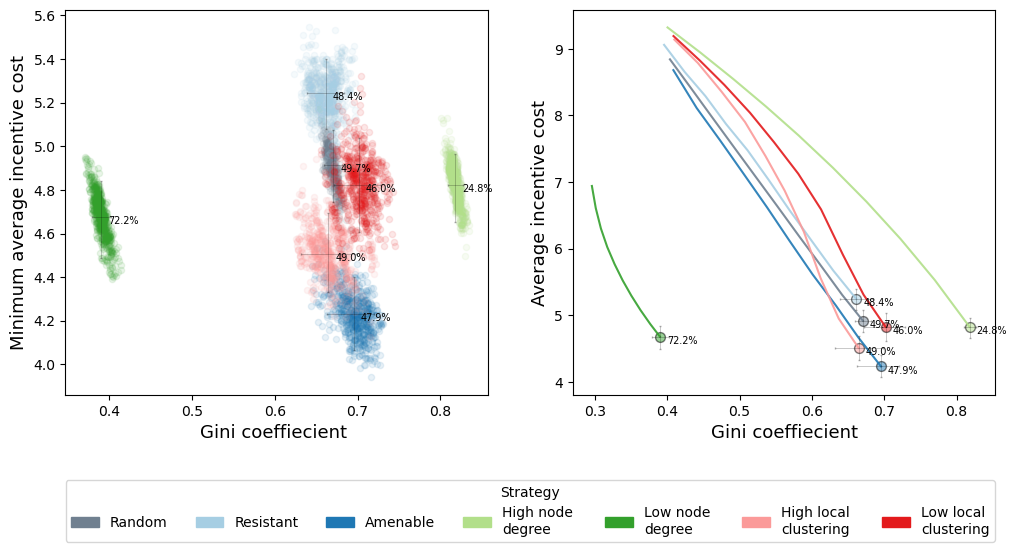

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 5))

for i in selected:
    
          
    ax2.plot(mean_G_all[i],mean_cost[i],color=colors[i],alpha=0.9)
                                        
    x=mean_G_all[i,0]
    y=mean_cost[i,0]
    

    xerr1=np.array([x-lower_G_all[i,0],upper_G_all[i,0]-x])
    yerr1=np.array([y-lower_cost[i,0],upper_cost[i,0]-y])

    ax2.scatter(x,y,color=colors[i],marker='o', s=50,edgecolor='k',alpha=0.5)
    ax1.scatter(G_all[i,:,0],incentive_cost[i,:,0],color=colors[i],marker='o', s=20,edgecolor=None,alpha=0.1)
    


    ax1.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax1.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    ax2.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax2.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    
ax2.set_ylabel('Average incentive cost',size=13)
ax1.set_ylabel('Minimum average incentive cost',size=13)
ax1.set_xlabel('Gini coeffiecient ',size=13)
ax2.set_xlabel('Gini coeffiecient',size=13)



handles, labels = ax1.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors[i], label=strategy_labels[i]) for i in selected ]
handles.extend(patches)
lgd=ax1.legend(handles=handles,loc='lower center',title='Strategy',fontsize="10", bbox_to_anchor=(1.1, -0.40),ncol=8, fancybox=True)

## Setting up population for Fig 3 (C,D)

In [96]:
#parameters of gamma distribution
mu=0.2
alpha=2


network=43 # preferenetial attachemnt with homophily
p_in=0.725 # corresponds to homophily=0.45(=2*(0.725-0.5))
phi_range_size=15

In [97]:
# generating preference values for populations
input_list= np.array([(N,mu,network,alpha,V) for ii in range(num_of_gamma_configs)], dtype=object)
gamma_list=p.starmap(gen_gamma,input_list)

rnd=666
rnd_list=range(666,666+num_of_networks)

# generating networks as well as criteria for network based strategies 
input_list= np.array([(network,N,z,0.5,rnd,strategy_type,p_in) for rnd,strategy_type in itertools.product(rnd_list,strategy_list)], dtype=object)
A_list,criteria_value_list=zip(*p.starmap(gen_net,input_list))

In [98]:
st = time.time()

incentive_cost=np.zeros((len(strategy_list),num_of_gamma_configs*num_of_networks,phi_range_size))
final_adoption=np.zeros_like(incentive_cost)
time_taken=np.zeros_like(incentive_cost)
G=np.zeros_like(incentive_cost)
G_all=np.zeros_like(incentive_cost)
phi_list=np.zeros((len(strategy_list),phi_range_size))

#identifying the minimum invervention for all strategies
input_list = np.array([(N, num_of_iter, num_of_replicates, A_list[ii],  gamma_list[i], penalty, strategy_list[ii%len(strategy_list)], criteria_value_list[ii], req) 
                       for i, ii in itertools.product(range(len(gamma_list)), range(len(A_list)))], dtype=object)
incentive_cost1,time_taken1,final_adoption1,phi_min1,G1,G_all1= zip(*p.starmap(min_intervention, input_list))

A_list=np.array(A_list)
A_list.shape=(num_of_networks,len(strategy_list),N,N)

criteria_value_list=np.array(criteria_value_list)
criteria_value_list.shape=(num_of_networks,len(strategy_list),N)

incentive_cost1=np.array(incentive_cost1)
incentive_cost1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))

final_adoption1=np.array(final_adoption1)
final_adoption1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))



time_taken1=np.array(time_taken1)
time_taken1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))

G1=np.array(G1)
G1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))
G_all1=np.array(G_all1)
G_all1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))


phi_min1=np.array(phi_min1)
phi_min1.shape=(num_of_gamma_configs*num_of_networks,len(strategy_list))
phi_min_mean=np.mean(phi_min1,axis=0)
phi_list[:,0]=phi_min_mean

for ii,strategy_type in enumerate(strategy_list):
            
    incentive_cost[ii,:,0]=incentive_cost1[:,ii]
    time_taken[ii,:,0]=time_taken1[:,ii]
    final_adoption[ii,:,0]=final_adoption1[:,ii]
    G[ii,:,0]=G1[:,ii]
    G_all[ii,:,0]=G_all1[:,ii]

    A_list1=list(A_list[:,ii,:,:])
    criteria_value_list1=list(criteria_value_list[:,ii,:])     

    phi_list1=np.linspace(phi_min_mean[ii],phi_limit,phi_range_size)

    # Looking at interventions beyond the minimum intervention size
    input_list = np.array([(N,num_of_iter,num_of_replicates,A_list1[ii],gamma_list[i],penalty,strategy_type,phi,criteria_value_list1[ii],req) for i,ii,phi in itertools.product(range(len(gamma_list)),range(len(A_list1)),phi_list1[1:])],dtype=object)
    incentive_cost2,time_taken2,final_adoption2,G2,G_all2 =zip(*p.starmap(simulation,input_list))

    incentive_cost2=np.array(incentive_cost2)
    incentive_cost2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    incentive_cost[ii,:,1:]=incentive_cost2

    final_adoption2=np.array(final_adoption2)
    final_adoption2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    final_adoption[ii,:,1:]=final_adoption2


    time_taken2=np.array(time_taken2)
    time_taken2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    time_taken[ii,:,1:]=time_taken2

    G2=np.array(G2)
    G2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    G[ii,:,1:]=G2

    G_all2=np.array(G_all2)
    G_all2.shape=(num_of_gamma_configs*num_of_networks,phi_range_size-1)
    G_all[ii,:,1:]=G_all2

    phi_list[ii,1:]=phi_list1[1:]

 # get the end time
et = time.time()    
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 23.29655361175537 seconds


In [99]:
spread=[5,95]
mean_cost=np.nanmean(incentive_cost,axis=1)
lower_cost= np.nanpercentile(incentive_cost,spread[0],axis=1)
upper_cost= np.nanpercentile(incentive_cost,spread[1],axis=1)

mean_time=np.nanmean(time_taken,axis=1)
lower_time= np.nanpercentile(time_taken,spread[0],axis=1)
upper_time= np.nanpercentile(time_taken,spread[1],axis=1)

mean_G=np.nanmean(G,axis=1)
lower_G= np.nanpercentile(G,spread[0],axis=1)
upper_G= np.nanpercentile(G,spread[1],axis=1)

mean_G_all=np.nanmean(G_all,axis=1)
lower_G_all= np.nanpercentile(G_all,spread[0],axis=1)
upper_G_all= np.nanpercentile(G_all,spread[1],axis=1)



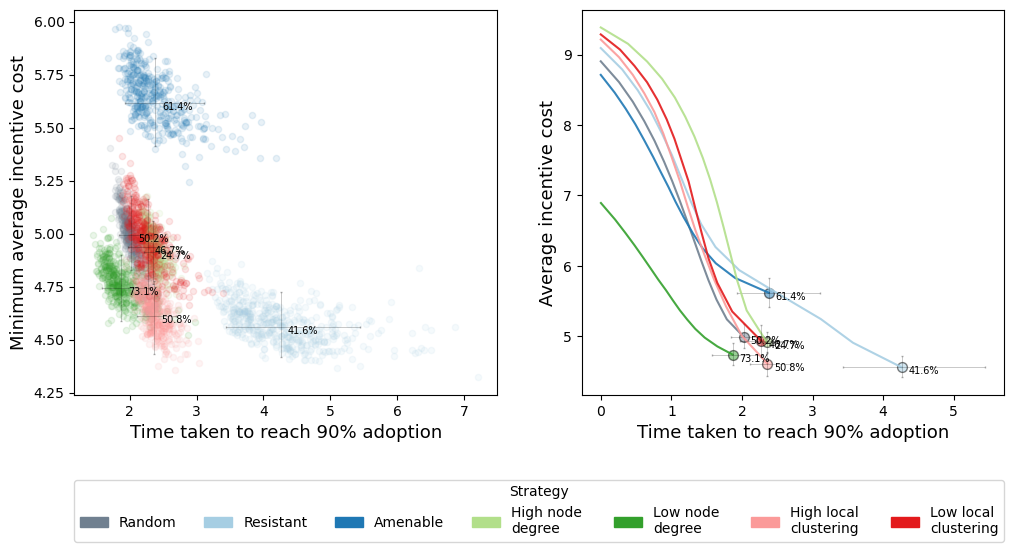

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 5))

for i in selected:
    
            
    ax2.plot(mean_time[i],mean_cost[i],color=colors[i],alpha=0.9)
    
    
                                    
    x=mean_time[i,0]
    y=mean_cost[i,0]
    

    xerr1=np.array([x-lower_time[i,0],upper_time[i,0]-x])
    yerr1=np.array([y-lower_cost[i,0],upper_cost[i,0]-y])

    ax2.scatter(x,y,color=colors[i],marker='o', s=50,edgecolor='k',alpha=0.5)
    ax1.scatter(time_taken[i,:,0],incentive_cost[i,:,0],color=colors[i],marker='o', s=20,edgecolor=None,alpha=0.1)
    


    ax1.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax1.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    ax2.errorbar(x, y, color=colors[i], xerr=[[xerr1[0]], [xerr1[1]]], yerr=[[yerr1[0]], [yerr1[1]]],fmt='', ecolor='k', elinewidth=0.5, capsize=0.5, linewidth=0, alpha=0.3)
    ax2.annotate(str(round(phi_list[i,0]*100,1))+'%', (x,y),textcoords="offset points",xytext=(5, -5), ha='left',fontsize=7)
    
ax2.set_ylabel('Average incentive cost',size=13)
ax1.set_ylabel('Minimum average incentive cost',size=13)
ax1.set_xlabel('Time taken to reach '+ str(int(req*100))+'% adoption',size=13)
ax2.set_xlabel('Time taken to reach '+ str(int(req*100))+'% adoption',size=13)


handles, labels = ax1.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors[i], label=strategy_labels[i]) for i in selected ]
handles.extend(patches)
lgd=ax1.legend(handles=handles,loc='lower center',title='Strategy',fontsize="10", bbox_to_anchor=(1.1, -0.40),ncol=8, fancybox=True)